In [1]:
# importing libraries
import os
import numpy as np
import cv2
import gc
from tqdm import tqdm
from glob import glob
import tensorflow as tf

In [2]:
# tensorflow version
print(tf.__version__)

2.12.0


### Data Collection and labeling

In [2]:
dirs = os.listdir('dataset')
dirs

['data_preprocess.npz',
 'Mask',
 'Mask_Chin',
 'Mask_Mouth_Chin',
 'Mask_Nose_Mouth']

In [8]:
#glob('dataset/Mask/*.jpg')
#["Mask"] * 20

In [4]:
glob(f"./dataset/Mask/*.jpg")

['./dataset/Mask\\00000.jpg',
 './dataset/Mask\\00001.jpg',
 './dataset/Mask\\00002.jpg',
 './dataset/Mask\\00003.jpg',
 './dataset/Mask\\00004.jpg',
 './dataset/Mask\\00005.jpg',
 './dataset/Mask\\00006.jpg',
 './dataset/Mask\\00007.jpg',
 './dataset/Mask\\00008.jpg',
 './dataset/Mask\\00009.jpg',
 './dataset/Mask\\00010.jpg',
 './dataset/Mask\\00011.jpg',
 './dataset/Mask\\00012.jpg',
 './dataset/Mask\\00013.jpg',
 './dataset/Mask\\00014.jpg',
 './dataset/Mask\\00015.jpg',
 './dataset/Mask\\00016.jpg',
 './dataset/Mask\\00017.jpg',
 './dataset/Mask\\00018.jpg',
 './dataset/Mask\\00019.jpg',
 './dataset/Mask\\00020.jpg',
 './dataset/Mask\\00021.jpg',
 './dataset/Mask\\00022.jpg',
 './dataset/Mask\\00023.jpg',
 './dataset/Mask\\00024.jpg',
 './dataset/Mask\\00025.jpg',
 './dataset/Mask\\00026.jpg',
 './dataset/Mask\\00027.jpg',
 './dataset/Mask\\00028.jpg',
 './dataset/Mask\\00029.jpg',
 './dataset/Mask\\00030.jpg',
 './dataset/Mask\\00031.jpg',
 './dataset/Mask\\00032.jpg',
 './datase

In [15]:
images_path = []
labels =[]
for folder in dirs:
    path = glob(f"./dataset/{folder}/*.jpg")
    label =['{}'.format(folder)]*len(path)
    images_path.extend(path)
    labels.extend(label)


In [16]:
print(images_path[:5])

['./dataset/Mask\\00000.jpg', './dataset/Mask\\00001.jpg', './dataset/Mask\\00002.jpg', './dataset/Mask\\00003.jpg', './dataset/Mask\\00004.jpg']


### Face Detection

In [17]:
image_path = images_path[5]
img = cv2.imread(image_path)
cv2.imshow('original',img)
cv2.waitKey()
cv2.destroyAllWindows()

In [18]:
face_detection_model = cv2.dnn.readNetFromCaffe('./models/deploy.prototxt.txt', './models/res10_300x300_ssd_iter_140000_fp16.caffemodel')

In [5]:
# blob from image (rgb mean substraction from image)
# The main reason for doing this is to center the data around zero, which can help the network converge faster and improve its performance. 
def face_detection_dnn(img):
    image = img.copy()
    h,w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image,1,(300,300),(104,117,123),swapRB=True)
    # get the detections
    face_detection_model.setInput(blob)
    detections = face_detection_model.forward()
    for i in range(0,detections.shape[2]):
        confidence = detections[0,0,i,2] # confidence score
        if confidence > 0.5:
            box = detections[0,0,i,3:7]*np.array([w,h,w,h])
            box = box.astype(int)
            #print(box)
            pt1 = (box[0],box[1])
            pt2 = (box[2],box[3])
            #cv2.rectangle(image,pt1,pt2,(0,255,0),2)
            roi = image[box[1]:box[3],box[0]:box[2]]

            return roi
    return None
        

In [8]:
roi = face_detection_dnn(img)
cv2.imshow("face",roi)
cv2.waitKey()
cv2.destroyAllWindows()

### Preprocessing

In [16]:
def datapreprocess(img):
    # blob from image (rgb mean subtraction image)
    face = face_detection_dnn(img)
    if face is not None:

        # computing blob from image
        blob = cv2.dnn.blobFromImage(face,1,(100,100),(104,117,123),swapRB=True)
        blob_squeeze = np.squeeze(blob).T
        blob_rotate = cv2.rotate(blob_squeeze,cv2.ROTATE_90_CLOCKWISE)
        blob_flip = cv2.flip(blob_rotate,1)
        # remove negative values and normalize
        img_norm = np.maximum(blob_flip,0)/blob_flip.max()
    
        return img_norm
    else:
        return None


### Apply to all images

In [17]:
#len(images_path)
data_img = []
label_img = []
i = 0
for path, label in tqdm(zip(images_path,labels),desc='preprocessing'):
    img = cv2.imread(path)
    process_img = datapreprocess(img)
    if process_img is not None:
        data_img.append(process_img)
        label_img.append(label)
          
    i += 1
    if i%100 == 0:
        gc.collect()

preprocessing: 10000it [10:21, 16.08it/s]


In [19]:
X = np.array(data_img)
y = np.array(label_img)

In [23]:
X.shape

(9959, 100, 100, 3)

In [20]:
#saving the images and labels
np.savez('./dataset/data_preprocess.npz',X,y)

### Training deep learning model

In [22]:
data = np.load('./dataset/data_preprocess.npz')

In [23]:
# load the images and labels
X = data['arr_0']
y = data['arr_1']

In [25]:
y

array(['Mask', 'Mask', 'Mask', ..., 'Mask_Nose_Mouth', 'Mask_Nose_Mouth',
       'Mask_Nose_Mouth'], dtype='<U15')

In [37]:
y.reshape(-1,1)

array([['Mask'],
       ['Mask'],
       ['Mask'],
       ...,
       ['Mask_Nose_Mouth'],
       ['Mask_Nose_Mouth'],
       ['Mask_Nose_Mouth']], dtype='<U15')

In [4]:
#one hot encoding for labels y 
from sklearn.preprocessing import OneHotEncoder
y_encoded = OneHotEncoder().fit_transform(y.reshape(-1,1))

In [5]:
y_array = y_encoded.toarray()
y_array

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

### splitting the data into train and test set

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y_array,test_size=0.2,random_state=42)

In [7]:
X_train.shape , X_test.shape

((7967, 100, 100, 3), (1992, 100, 100, 3))

In [8]:
cv2.imshow('original',X_train[5555])
cv2.waitKey()
cv2.destroyAllWindows()

In [9]:
# convolution neural network (Le-Net architecture)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,3,padding='same',input_shape=(100,100,3),activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32,3,padding='same',activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64,3,padding='same',activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(192,activation='relu'),
    tf.keras.layers.Dense(28,activation='relu'),
    tf.keras.layers.Dense(4,activation='sigmoid')
])


# compiling CNN
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.categorical_crossentropy,metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0

In [11]:
# Training CNN
history = model.fit(x=X_train,y=y_train,validation_data=(X_test,y_test),batch_size=30,epochs=20)

Epoch 1/20
266/266 [==============================] - 47s 173ms/step - loss: 0.2174 - accuracy: 0.9195 - val_loss: 0.0779 - val_accuracy: 0.9779
Epoch 2/20
266/266 [==============================] - 48s 180ms/step - loss: 0.0633 - accuracy: 0.9790 - val_loss: 0.0490 - val_accuracy: 0.9839
Epoch 3/20
266/266 [==============================] - 45s 169ms/step - loss: 0.0422 - accuracy: 0.9844 - val_loss: 0.0655 - val_accuracy: 0.9799
Epoch 4/20
266/266 [==============================] - 45s 168ms/step - loss: 0.0323 - accuracy: 0.9878 - val_loss: 0.0488 - val_accuracy: 0.9809
Epoch 5/20
266/266 [==============================] - 43s 163ms/step - loss: 0.0188 - accuracy: 0.9931 - val_loss: 0.0483 - val_accuracy: 0.9859
Epoch 6/20
266/266 [==============================] - 43s 163ms/step - loss: 0.0175 - accuracy: 0.9942 - val_loss: 0.0443 - val_accuracy: 0.9874
Epoch 7/20
266/266 [==============================] - 40s 152ms/step - loss: 0.0100 - accuracy: 0.9964 - val_loss: 0.1155 - val_ac

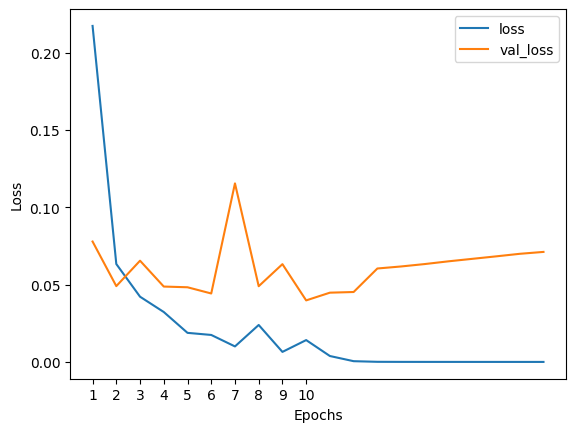

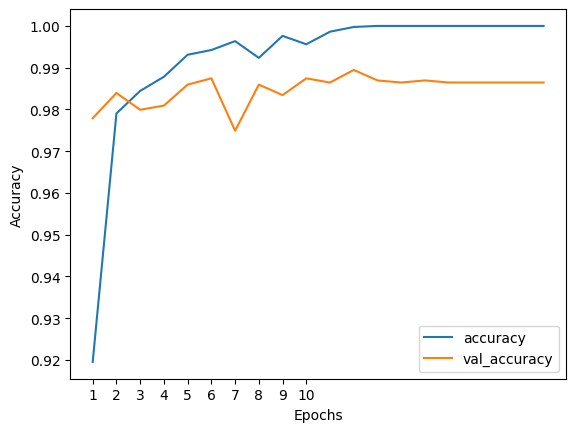

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)

history_df

history_df[['loss','val_loss']].plot(kind='line')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(list(range(10)),list(range(1,11)))
plt.show()

history_df[['accuracy','val_accuracy']].plot(kind='line')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(list(range(10)),list(range(1,11)))
plt.show()



In [14]:
# Save CNN Model
model.save('face_cnn_model')

INFO:tensorflow:Assets written to: face_cnn_model\assets


INFO:tensorflow:Assets written to: face_cnn_model\assets


## Prediction :

In [3]:
face_detection_model = cv2.dnn.readNetFromCaffe('./models/deploy.prototxt.txt', './models/res10_300x300_ssd_iter_140000_fp16.caffemodel')
face_mask_detection_model = tf.keras.models.load_model("face_cnn_model/")

In [4]:
labels = ["Mask","No Mask","Covered Mouth Chin","Covered Nose Mouth"]
def get_color(label):
   if label =="Mask":
       color =(0,255,0) #green
   elif label =="No Mask":
       color = (0,0,255)
   elif label =="Covered Mouth Chin":
       color = (0,255,255)
   else :
       color = (255,255,0)
   return color    

In [5]:
from scipy.special import softmax

In [8]:
def face_mask_prediction(img):
    # step - 1 : face detection
    image = img.copy()
    h, w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image,1,(300,300),(104,117,123),swapRB=True)
    # 
    face_detection_model.setInput(blob)
    detection = face_detection_model.forward() # it will give the detection
    for i in range(0,detection.shape[2]):
        confidence = detection[0,0,i,2]
        if confidence > 0.5:
            box = detection[0,0,i,3:7]*np.array([w,h,w,h])
            box = box.astype(int)
            pt1 = (box[0], box[1])
            pt2 = (box[2], box[3])
            # cv2.rectangle(image,pt1,pt2,(0,255,0),1)

            # step -2: Data preprocessing
            face = image[box[1]:box[3],box[0]:box[2]]
            face_blob = cv2.dnn.blobFromImage(face,1,(100,100),(104,117,123),swapRB=True)
            face_blob_squeeze = np.squeeze(face_blob).T
            face_blob_rotate = cv2.rotate(face_blob_squeeze,cv2.ROTATE_90_CLOCKWISE)
            face_blob_flip = cv2.flip(face_blob_rotate,1)
            # normalization
            img_norm = np.maximum(face_blob_flip,0)/face_blob_flip.max()
            # step-3: Deep Learning (CNN)
            img_input = img_norm.reshape(1,100,100,3)
            result = face_mask_detection_model.predict(img_input)
            result = softmax(result)[0]
            confidence_index = result.argmax()
            confidence_score = result[confidence_index]
            label = labels[confidence_index]
            label_text = '{}: {:,.0f} %'.format(label,confidence_score*100)
            #print(label_text)
            # color
            color = get_color(label)
            cv2.rectangle(image,pt1,pt2,color,1)
            cv2.putText(image,label_text,pt1,cv2.FONT_HERSHEY_PLAIN,2,color,2)
            
    return image

In [9]:
# recognition code
img = cv2.imread('women-wearing-mask.jpg')

image = face_mask_prediction(img)


cv2.imshow('predictions',image)
cv2.waitKey()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 324ms/step


In [10]:
cap = cv2.VideoCapture(0)

while True:
    ret, frames = cap.read()
    if ret == False:
        break
        
    image = face_mask_prediction(frames)
    cv2.imshow('Face Mask Prediction',image)
    if cv2.waitKey(1) == 27:
        break
        
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 25ms/step


KeyboardInterrupt: 

: 